<a href="https://colab.research.google.com/github/Rahul-Singh-10/Google-Analytics-Ecommerce-Predition_Model/blob/main/04_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4.1 Imports
Inital steps are to import crtical libraries and import the parquet fil.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import missingno as msno
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/finaldf1.parquet')
pd.set_option("display.max_columns", None)

#4.2 Data cleaning:
Before spliting our data for train/test split , we need to clean date field with correct data type and remove data from before 09/01/2017 to identify a datum point.

In [ ]:
df['Date_fmt'] = pd.to_datetime(df['Date_fmt'])

In [ ]:
df = df[df['Date_fmt'] > '2016-08-31'].set_index('Date_fmt').fillna(-9999)

In [ ]:
df1 = df.drop(columns = ['prev_date','visit_capture','Churn_$30d','Churn_$15d','Churn_vc30d','visitId',"visitFreq_N30d", "visitFreq_N15d", "visitFreq_L15d", "visitFreq_L30d"]) #Churn_vf30d

In [ ]:
df1.head()

#4.3 Train/Test split:
We need to train/test split the dataset at 70/30 ratio. For function Y we need to isolate our field labled Churn as our outcome varaible. X vector will have all the input fields besides the churn column.

In [ ]:
X1=df1.drop(columns = 'Churn_vf30d')
y1=df1['Churn_vf30d']

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split (X1,y1,test_size=0.3, random_state=1)

## 4.4 Modeling: Random Forest Model


In [ ]:
y1_test.value_counts()

1    226419
0     22250
Name: Churn_vf30d, dtype: int64

In [ ]:
clf = RandomForestClassifier(n_estimators=60,random_state=42,n_jobs=-1,max_depth = 4,max_features='sqrt',min_samples_leaf=5,min_samples_split=5)
m1 = clf.fit(X1_train,y1_train)
y1_pred = m1.predict(X1_test)


ac1 = accuracy_score(y1_test,y1_pred)#accuracy
cm = confusion_matrix(y1_test,y1_pred)

print('Random forest m1: Accuracy =',ac1)
print('Confusion matrix = ',cm)

Random forest m1: Accuracy = 0.9176334806509858
Confusion matrix =  [[  2861  19389]
 [  1093 225326]]


random forest model provides us with accuracy of 0.9176 at 91.76%
through confusion matrix we can see TP value to be 225326 and FN&FP = 2861+196389 = 4799 values that need to be tunned as they being recorded incorrectly

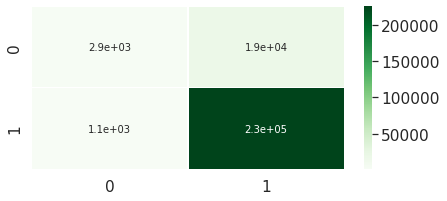

In [ ]:
plt.figure(figsize=(7,3)) #confusion matrix: this shows percantage of true positive/false positive/true negatives/false negatives values that are being predicted by model
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

#Hyperparameter Tuning 
We need to tune the ranfom forest model to improve confusion matrix output values and have more TP values. we establish n_estimators ( # of tress in random forest) , max features,max depth, min sample split and min sample require at each leaf node.

In [ ]:
n_estimators= [int(x) for x in np.linspace(start = 10,stop = 100,num = 10)] # of trees in random forest
max_features = ['sqrt'] # of features to consider at every split
max_depth = [2,4] #2,4max number of levels in tree
min_sam_split = [2,5] #2,5min number of samples required to split a node
min_sam_leaf = [3,4,5] #1,2min number of samploes require at each leaf node
bootstrap = [True]

#parameter grid
param_grid = {'n_estimators':n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split':min_sam_split,
              'min_samples_leaf': min_sam_leaf,
              'bootstrap':bootstrap}

print(param_grid)

from sklearn.model_selection import GridSearchCV
rfmodel = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rfmodel,param_grid = param_grid,cv=4,verbose=2,n_jobs=-1)
rf_grid.fit(X1_train,y1_train)
rf_grid.best_params_

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [3, 4, 5], 'bootstrap': [True]}
Fitting 4 folds for each of 120 candidates, totalling 480 fits


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 60}

<BarContainer object of 84 artists>

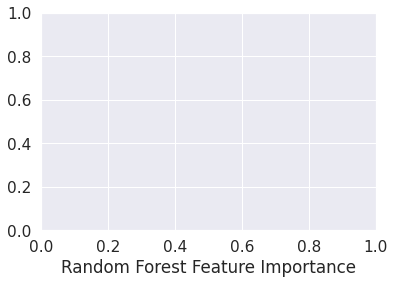

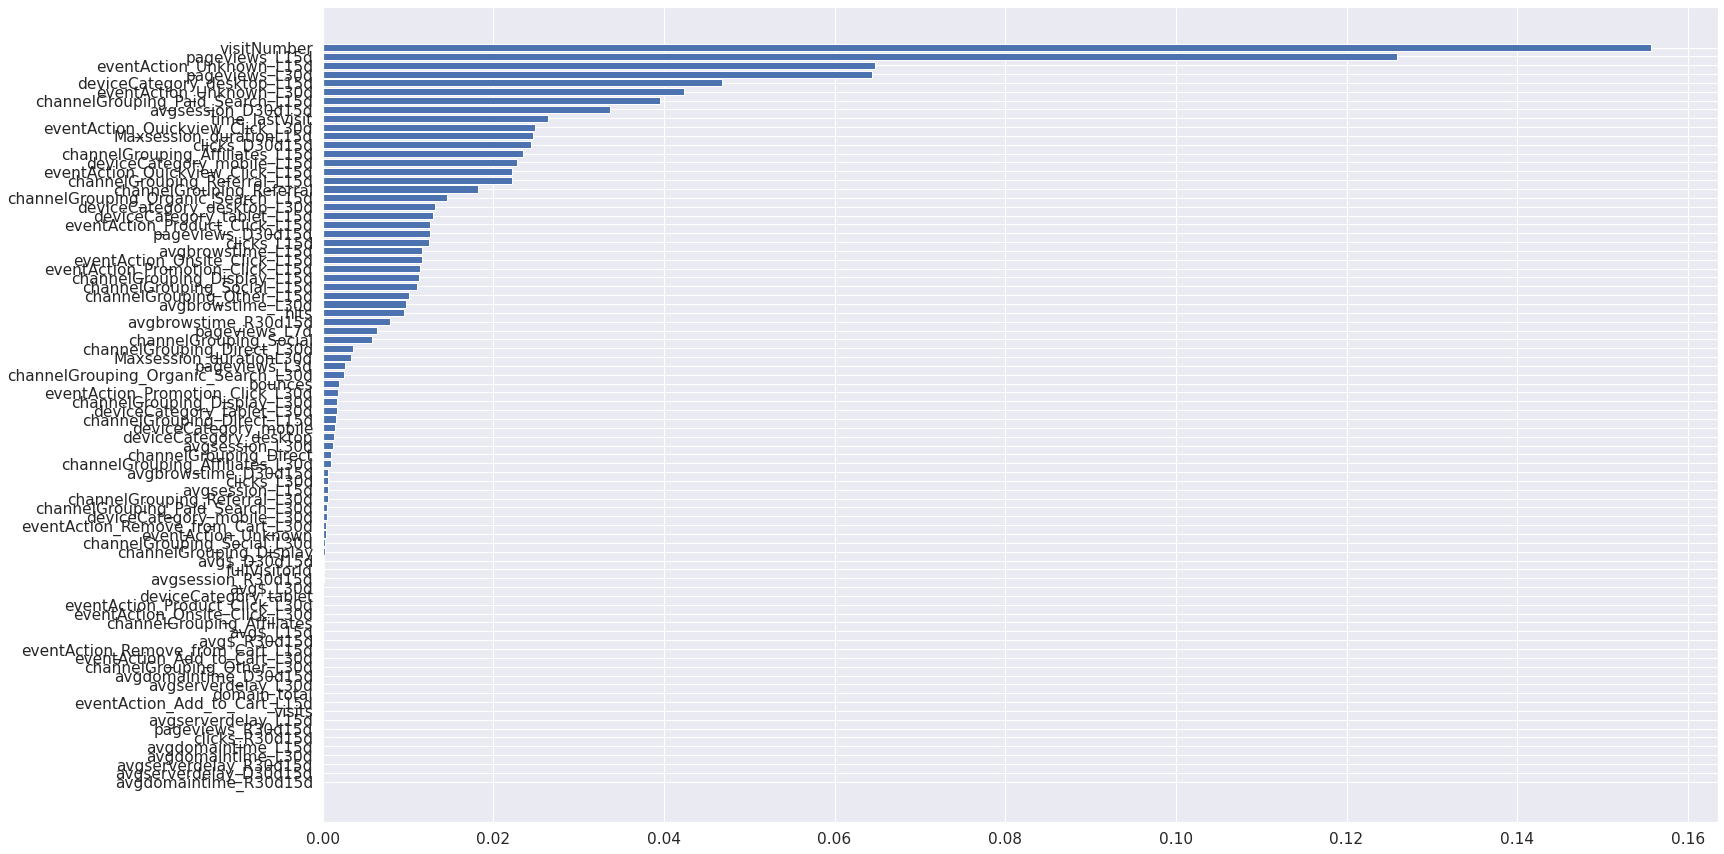

In [ ]:
sorted_idx = clf.feature_importances_.argsort()
#plt.barh(X1_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

plt.figure(figsize=(25, 15))
plt.barh(X1_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])

In [ ]:
clf_fin = RandomForestClassifier(n_estimators=20,random_state=42,n_jobs=-1,max_depth = 4,max_features='sqrt',min_samples_leaf=3,min_samples_split=2)
m1 = clf_fin.fit(X1_train,y1_train)

y1_pred = m1.predict(X1_test)

ac1 = accuracy_score(y1_test,y1_pred)

cm = confusion_matrix(y1_test,y1_pred)

print('Random forest m1: Accuracy =',ac1)#frequency
print('Confusion matrix = ',cm)

Random forest m1: Accuracy = 0.9174887098914621
Confusion matrix =  [[  2815  19435]
 [  1083 225336]]


Hyperparameter tunning didn't result in any additional improvement as the model seemed to be overfitting the data but we still need to address all incorrect output values and that is done through optimizing predict functions with values


In [ ]:
def calc_KS(y_true,y_pred,n_groups=10):
    ro_df = pd.DataFrame({'Actual':y_true,'Predicted':y_pred}).sort_values('Predicted',ascending=False)
    ro_df = ro_df.reset_index()
    ro_df['index'] = ro_df.index
    ro_df['groups'] = np.ceil(((ro_df['index']+1) *n_groups/ro_df.shape[0]).values).astype(np.int8)
    smry = ro_df.groupby('groups').agg({'index': 'count','Predicted':[ np.min, np.max,np.mean],'Actual':np.sum})
    smry.columns = smry.columns.droplevel(0)
    smry = smry.reset_index()
    smry = smry.rename(columns={'sum':'Actual'})
    smry['Actual'] = smry['Actual'].astype(np.int32)
    smry['Non-Responders'] = (smry['count'] - smry['Actual']).astype(np.int32)
    smry = smry.rename(columns={'groups':'Tier','count':'Observations','mean':'Mean-Prob','amin':'Min-Prob','amax':'Max-Prob','Actual':'Responders'})
    smry['Cum-Response(%)'] = np.round((smry['Responders'].cumsum()/ smry['Responders'].sum())*100,2)
    smry['Cum-Non-Response(%)'] = np.round((smry['Non-Responders'].cumsum()/ smry['Non-Responders'].sum())*100,2)
    smry['Response-Rate(%)'] = smry['Responders']*100/smry['Observations']
    smry['KS-Score'] = np.round((smry['Cum-Response(%)'] - smry['Cum-Non-Response(%)']),2)
    return smry[['Tier', 'Observations', 'Min-Prob', 'Mean-Prob', 'Max-Prob',
           'Responders', 'Non-Responders','Response-Rate(%)', 'Cum-Response(%)',
           'Cum-Non-Response(%)', 'KS-Score']]

In [ ]:
calc_KS(y1_test, y1_pred_prob)

,Tier,Observations,Min-Prob,Mean-Prob,Max-Prob,Responders,Non-Responders,Response-Rate(%),Cum-Response(%),Cum-Non-Response(%),KS-Score
0,1,24866,0.956997,0.958080,0.960987,24494,372,98.503981,10.82,1.67,9.15
1,2,24867,0.956997,0.956997,0.956997,24548,319,98.717175,21.66,3.11,18.55
2,3,24867,0.952481,0.953999,0.956997,24381,486,98.045603,32.43,5.29,27.14
3,4,24867,0.950764,0.951506,0.952481,24086,781,96.859291,43.07,8.80,34.27
4,5,24867,0.949844,0.950672,0.950764,24102,765,96.923634,53.71,12.24,41.47
5,6,24867,0.945972,0.947784,0.949844,23727,1140,95.415611,64.19,17.36,46.83
6,7,24867,0.936157,0.942052,0.945972,23098,1769,92.886154,74.39,25.31,49.08
7,8,24867,0.907874,0.920683,0.936157,22223,2644,89.367435,84.21,37.20,47.01
8,9,24867,0.844435,0.882020,0.907874,20241,4626,81.397032,93.15,57.99,35.16
9,10,24867,0.114378,0.642490,0.844435,15519,9348,62.408011,100.00,100.00,0.00


<BarContainer object of 84 artists>

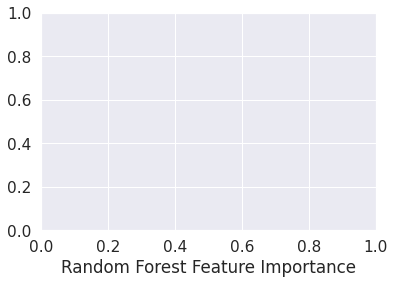

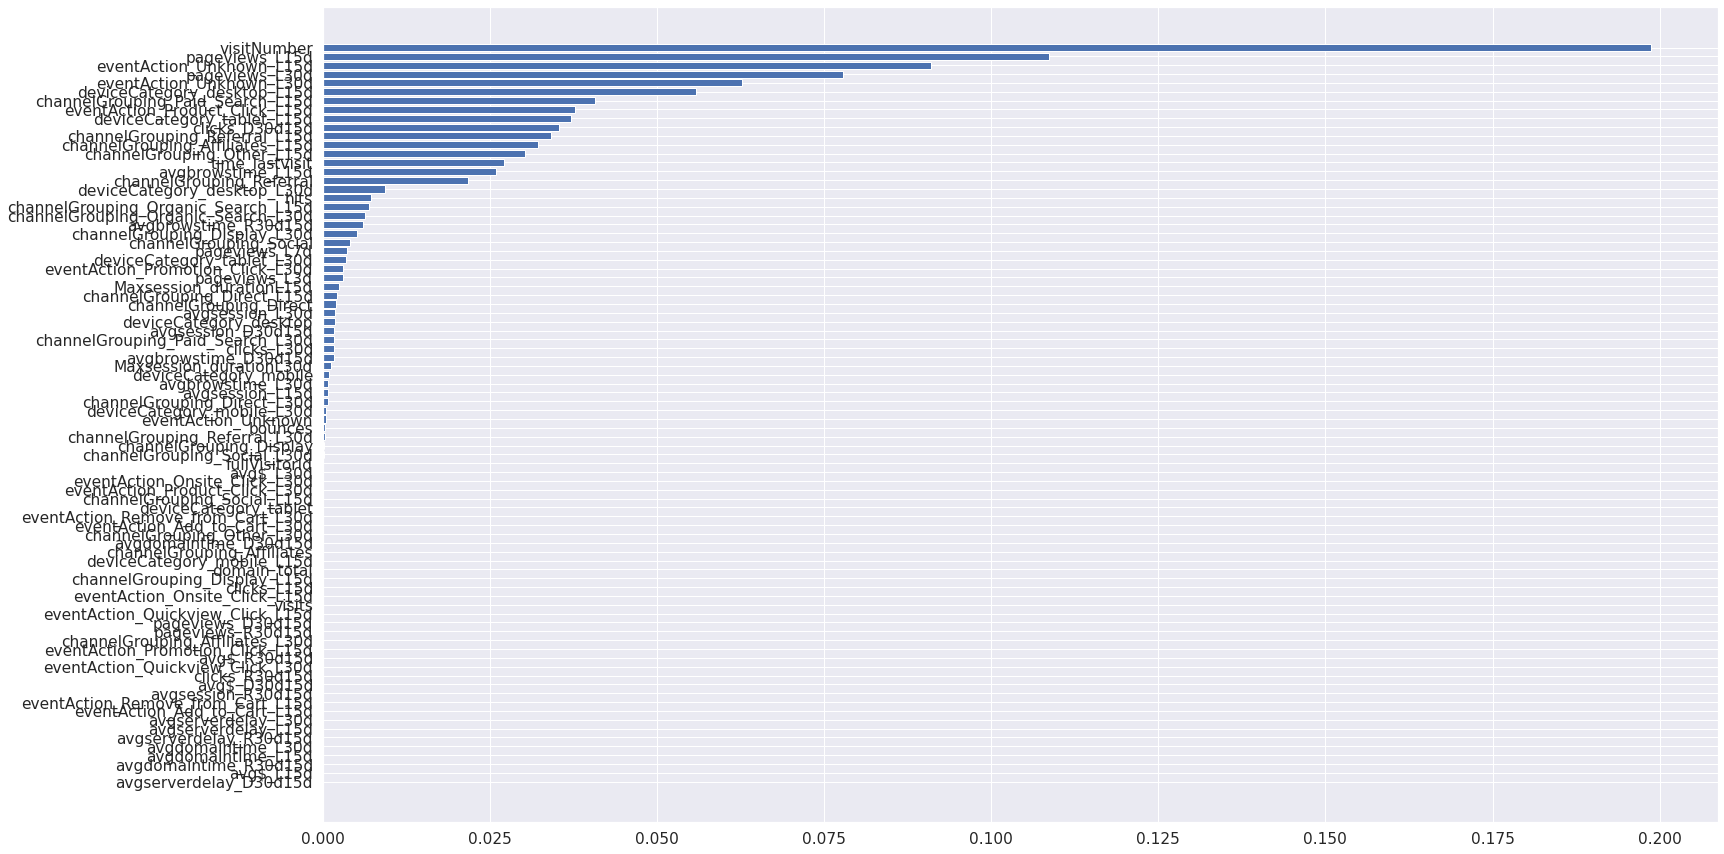

In [ ]:
sorted_idx = clf_fin.feature_importances_.argsort()
#plt.barh(X1_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

plt.figure(figsize=(25, 15))
plt.barh(X1_train.columns[sorted_idx], clf_fin.feature_importances_[sorted_idx])

In [ ]:
def get_prob_cutoff( ytrue, ypred):
    pmn = ypred.min()
    pmx = ypred.max()
    f1 = []
    for i in np.arange(pmn,pmx,.01):
            f1.append((np.round(i,2),f1_score(ytrue,ypred>=np.round(i,2))))
    return list(dict(f1).keys())[np.argmax(list(dict(f1).values()))]

In [ ]:
y1_pred_prob = m1.predict_proba(X1_test)[:,1]
y1_pred_prob[:4]

array([0.95076418, 0.93605315, 0.95699691, 0.89788679])

In [ ]:
get_prob_cutoff(y1_test, y1_pred_prob)

0.54

In [ ]:
y_pred_out = np.where(y1_pred_prob >= 0.54, 1, 0)

confusion_matrix(y1_test,y_pred_out)

array([[  3266,  18984],
       [  1453, 224966]])

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y1_test, y1_pred_prob)

0.8178938819354056